<a href="https://colab.research.google.com/github/EilieYoun/Narnia-Edu/blob/main/Lecture/240813_snu/01_2D_Scalar_Predict_%ED%95%B4%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서울대 예측 AI 실습 : 2D Scalar Predict

* 날짜:
* 이름:


## 학습내용
```
- 2D 데이터셋에 대해 이해하고 적절한 DataLoader를 구성 한다.
- 2D scalar 예측 문제에 적합한 모델을 구성하고, 학습을 진행한다.
```

## **(0) 환경세팅**
---

### **| 라이브러리 설치**

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 12.5 MB/s eta 0:00:00


### **| 데이터 압축 풀기**

In [ ]:
!unzip carhood_npy.zip -d carhood_npy

### **| Utils**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go
from PIL import Image

def draw_scatter_plotly(df, name, x, y, sample=None, marker_size=8, plot_width=700, plot_height=500):
    if sample is not None:
        df = df.sample(sample)

    fig = go.Figure()

    # Scatter plots
    fig.add_trace(go.Scatter(
        x=df[x],
        y=df[y],
        mode='markers',
        marker=dict(size=marker_size, color='blue'),
        text=df[name],  # Hover할 때 보일 텍스트 설정
        hoverinfo='text+x+y',  # Hover할 때 name, x, y 값만 보이도록 설정
        name=f'{x} vs {y}'
    ))

    # 레이아웃 설정
    fig.update_layout(
        title=f'{x} vs {y}',
        xaxis_title=x,
        yaxis_title=y,
        width=plot_width,
        height=plot_height
    )

    fig.show()

def draw_img_from_cond(skin, geo, cmap='gray'):
    plt.figure(figsize=(3,3))
    path = f'carhood_npy/skin_{skin}_geometry_{geo}.npy'
    img = np.load(path)
    plt.imshow(img, cmap=cmap)
    plt.show()
    return img


def draw_3d(depth_map):
    # 3D 플로팅
    fig = plt.figure(figsize=(16, 8))

    # x, y 좌표 생성
    x = np.arange(0, depth_map.shape[1], 1)
    y = np.arange(0, depth_map.shape[0], 1)
    x, y = np.meshgrid(x, y)


    ax2 = fig.add_subplot(131, projection='3d')
    surface2 = ax2.plot_surface(x, y, depth_map, cmap='viridis')
    ax2.set_axis_off()
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Depth')
    ax2.view_init(elev=0, azim=90)

    ax = fig.add_subplot(132, projection='3d')
    surface1 = ax.plot_surface(x, y, depth_map, cmap='viridis')
    ax.set_axis_off()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Depth')
    ax.view_init(elev=60, azim=60)


    ax1 = fig.add_subplot(133, projection='3d')
    surface1 = ax1.plot_surface(x, y, depth_map, cmap='viridis')
    ax1.set_axis_off()
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Depth')
    fig.colorbar(surface1, ax=ax1, shrink=0.5, aspect=10)
    ax1.view_init(elev=0, azim=30)

    # 플롯 출력
    plt.show()


def draw_dist(inputs, samples=100):
    if len(inputs) > samples:
        inputs = random.sample(list(inputs), samples)

    pixel_values = []
    for item in inputs:
        if isinstance(item, Image.Image):
            pixel_values.extend(list(item.getdata()))
        elif isinstance(item, np.ndarray):
            pixel_values.extend(item.flatten())
        elif torch.is_tensor(item):
            if len(item.shape) == 4 and item.shape[1] == 1:  # 이미지가 (batch_size, 1, height, width) 꼴일 때
                item = item.squeeze(1)
            elif len(item.shape) == 3:  # 이미지가 (batch_size, height, width) 꼴일 때
                item = item.unsqueeze(1)
            else:
                raise ValueError("Unsupported image shape. Supported shapes: (batch_size, height, width) or (batch_size, 1, height, width).")
            item = item.detach().cpu().numpy()
            pixel_values.extend(item.flatten())
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

    plt.figure(figsize=(5,3))
    plt.hist(pixel_values, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Image Pixel Value Distribution')
    plt.show()


def draw_imgs(images_list,
             r=1,
             cmap='gray',
             img_size=(5, 5),
             axis="off",
             colorbar=False,
             save_path=None,):
    if r < 1:
        r = 1

    total_images = len(images_list)
    if total_images == 0:
        print("No images to display.")
        return

    cols = (total_images + r - 1) // r
    fig, axs = plt.subplots(r, cols, figsize=(cols * img_size[0], r * img_size[1]))

    if r == 1:
        axs = axs.reshape(1, -1)

    for idx, item in enumerate(images_list):
        ax = axs[0, idx] if r == 1 else axs[idx // cols, idx % cols]
        im = None
        if isinstance(item, Image.Image):
            if item.mode in ['L', '1']:  # Grayscale images
                im = ax.imshow(item, cmap=cmap)
            else:  # Color images
                im = ax.imshow(item)
        elif isinstance(item, np.ndarray):
            if item.ndim == 2:  # 2D array, grayscale image
                im = ax.imshow(item, cmap=cmap)
            elif item.ndim == 3:  # 3D array, color image
                im = ax.imshow(item, cmap=cmap if item.shape[-1] == 1 else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D array with batch dimension of 1
                im = ax.imshow(item[0], cmap=cmap if item.shape[1] == 1 else None)
            else:
                raise ValueError(f"Unsupported numpy array shape: {item.shape}.")
        elif torch.is_tensor(item):
            item = item.detach().cpu().numpy()
            if item.ndim == 2:  # 2D tensor, grayscale image
                im = ax.imshow(item, cmap=cmap)
            elif item.ndim == 3:  # 3D tensor, color image
                im = ax.imshow(item.transpose(1, 2, 0), cmap=cmap if item.shape[0] == 1 else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D tensor with batch dimension of 1
                im = ax.imshow(item[0].transpose(1, 2, 0), cmap=cmap if item.shape[1] == 1 else None)
            else:
                raise ValueError(f"Unsupported torch tensor shape: {item.shape}.")
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

        if colorbar and im is not None:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax)

        ax.axis(axis)

    plt.tight_layout()
    # 이미지 저장
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


def draw_results(preds, targets, titles=[]):

    num_vars = preds.shape[1]

    # 그래프 크기 설정
    fig, axes = plt.subplots(1, num_vars, figsize=(num_vars * 6, 6))

    for i in range(num_vars):
        ax = axes[i]
        ax.scatter(targets[:, i], preds[:, i], alpha=0.5)
        ax.plot([targets[:, i].min(), targets[:, i].max()], [targets[:, i].min(), targets[:, i].max()], 'r--')
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')

        if titles and i < len(titles):
            ax.set_title(titles[i])
        else:
            ax.set_title(f'Variable {i+1}')

    plt.tight_layout()
    plt.show()

## **(1) Dataset**

### **| EDA**

**데이터 소개**


`CarHoods10k` 데이터셋은 10,000개 이상의 자동차 후드 프레임 3D 메쉬 형상으로 구성되었으며, 자동화된 CAD 워크플로우를 통해 생성되었습니다. 이 데이터셋은 현실성과 제조 가능성에 대해 전문가의 검증을 거쳤습니다. 기초 형상 및 FEA(유한 요소 해석) 성능 지표가 포함되어 있으며, 자동차 공학 및 기타 분야에서 최적화 및 머신러닝 방법을 평가하고 개발하는 데 유용한 데이터를 제공합니다​ (DataDryad)​.

`CarHoods10k` 데이터셋은 `Creative Commons Zero (CC0)` 라이센스로 제공됩니다. 이 라이센스는 사용자가 저작권을 포기한 것으로, 누구나 자유롭게 데이터를 복제, 수정, 배포, 심지어 상업적 목적으로도 사용할 수 있습니다. 사용자는 출처를 명시할 필요가 없으며, 데이터 사용에 대한 법적 제한이 없습니다

이번 시간에 다룰 데이터는 `CarHood10k` 메쉬 데이터셋을 256x256 해상도의 depthmap으로 가공한 것입니다. 전체 데이터 중 무작위로 선택한 1,000개의 `depthmap npy` 파일을 사용하여 실습을 진행할 예정입니다. 이 데이터를 통해 자동차 후드의 성능을 예측하는 방법을 배우고자 합니다.

**성능 변수 확인**



* `Equivalent Stress Maximum (MPa)`: 이 값은 von Mises stress의 최대값을 의미합니다. von Mises stress는 재료의 복잡한 응력 상태를 단일 응력 값으로 나타내는 방법 중 하나입니다.  von Mises stress 값이 낮을 수록 동일한 하중 조건에서 제품의 파손이 잘 발생하지 않기 때문에 Car hood의 안전성을 판단하는데 사용됩니다.


* `Geometry Mass (kg)`: 이 값은 Car hood의 질량을 나타내며, 일반적으로 제품의 무게를 측정하는 데 사용됩니다. 일반적으로는 Car hood가 더 가볍을수록 연료 효율성이 좋아지고, 주행 성능이 향상될 수 있습니다.

* `Directional Deformation Maximum (mm)`: 이 값은 Car hood의 변형량 중에서 가장 큰 값입니다. 이 값이 작을수록 Car hood가 보다 견고하고, 형태 유지가 뛰어남을 의미합니다. 따라서 작은 값이 더 좋습니다.

In [ ]:
import pandas as pd
df = pd.read_csv('carhood_annot.csv')
df.head()

,name,Equivalent Stress Maximum (MPa),Geometry Mass (kg),Directional Deformation Maximum (mm),OutputNumber
0,skin_46_geometry_97,70.350375,12.443655,2.281199,97
1,skin_28_geometry_49,170.740883,10.945643,17.687122,49
2,skin_63_geometry_95,239.574988,12.827289,9.348031,95
3,skin_94_geometry_26,239.637144,13.171650,11.577218,26
4,skin_88_geometry_70,159.222052,14.050113,8.998617,70


**데이터 분포 시각화**

In [ ]:
cols = list(df.columns)
print(cols)

draw_scatter_plotly(df, cols[0], cols[2], cols[1])
draw_scatter_plotly(df, cols[0], cols[2], cols[3])
draw_scatter_plotly(df, cols[0], cols[1], cols[3])

['name', 'Equivalent Stress Maximum (MPa)', 'Geometry Mass (kg)', 'Directional Deformation Maximum (mm)', 'OutputNumber']


**Depthmap 이미지 시각화**

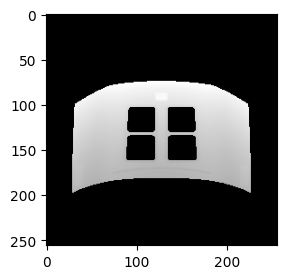

(256, 256)


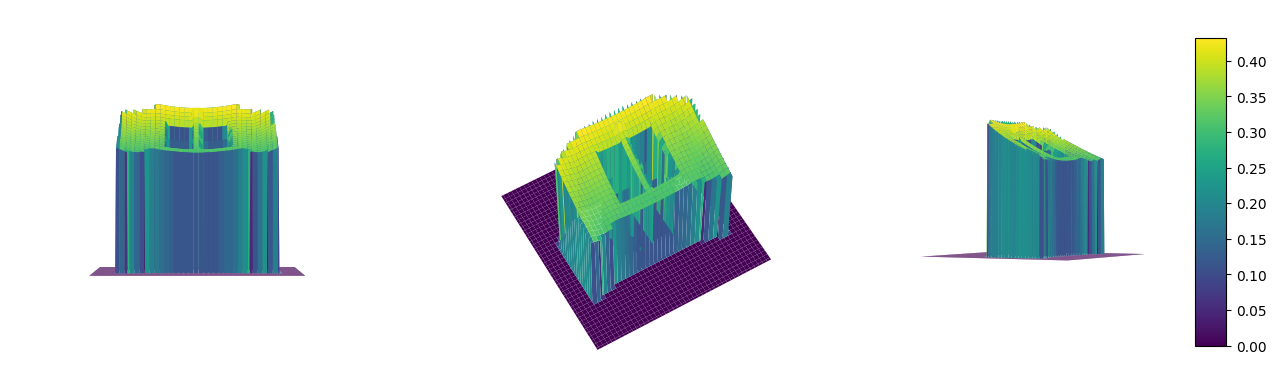

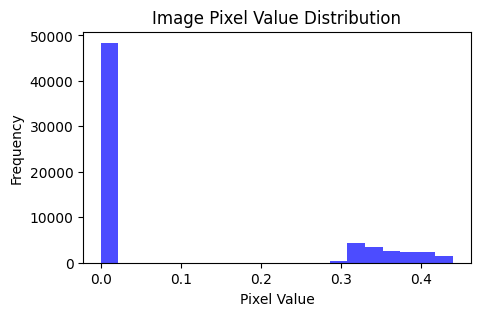

In [ ]:
img = draw_img_from_cond(41, 29)
print(img.shape)
draw_3d(img)
draw_dist([img])

### **| DataLoader**

간략하게 데이터 구성을 확인했으니 이를 적절한 DataLoader 클래스를 구축하겠습니다. DataLoader는 아래와 같은 기능이 포함되어야 합니다.

```
- __init__ : 데이터셋 초기화.
    - df: 데이터프레임, 메타데이터를 포함.
    - data_dir: 데이터 파일 경로.
    - name_column: 데이터 파일 이름을 포함하는 열.
    - var_columns: 정규화할 변수 열.
    - scaler: 데이터 정규화에 사용할 스케일러, 없으면 StandardScaler를 사용.
    - batch_size: 배치 크기.
    - shuffle: 데이터 셔플 여부.
    - dtype: 데이터 유형 (torch.float32 기본값).

- __len__ : 데이터셋의 전체 길이를 반환.

- __getitem__ : 인덱스에 해당하는 데이터 항목을 반환.
    - DataFrame을 로드하여 필요한 데이터 불러오기
    - Numpy 데이터를 적절하게 정규화
    - 성능 변수를 적절하게 정규화
    - 전처리된 인풋 텐서 (x)와 타깃 텐서 (y) 반환

- get_loader : 데이터 로더를 반환.

- get_batch : 지정된 인덱스의 배치를 반환.
```


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class CarHoodProcess(Dataset):

    def __init__(self,
                 df,
                 data_dir,
                 name_column,
                 var_columns=[],
                 scaler=None,
                 batch_size=32,
                 shuffle=True,
                 dtype=torch.float32
                ):
        # init
        self.df = df
        self.data_dir = data_dir
        self.name_column = name_column
        self.var_columns = var_columns

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dtype = dtype

        if scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(self.df[self.var_columns])
        else:
            self.scaler = scaler

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        items = self.df.iloc[idx]

        name = items[self.name_column]
        path = f'{data_dir}/{name}.npy'
        arr = np.load(path)

        non_zero_values = arr[np.where(arr != 0)]
        mean = np.mean(non_zero_values)
        std = np.std(non_zero_values)
        normalized_values = (non_zero_values - mean) / std

        x = np.zeros_like(arr)
        x[np.where(arr != 0)] = normalized_values
        x = torch.tensor(x, dtype=self.dtype)
        x = x.unsqueeze(0)

        y = list(items[self.var_columns])
        df = pd.DataFrame([y], columns=self.var_columns)
        y = self.scaler.transform(df)  # 정규화
        y = torch.tensor(y[0], dtype=self.dtype)
        return x, y

    def get_loader(self):
        loader = DataLoader(self, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        return loader

    def get_batch(self, idx=0):
        ds = self.get_loader()
        for i, batch in enumerate(ds):
            if i == idx : break
        return batch

**DataLoader 테스트**

torch.Size([32, 1, 256, 256]) torch.Size([32, 3])


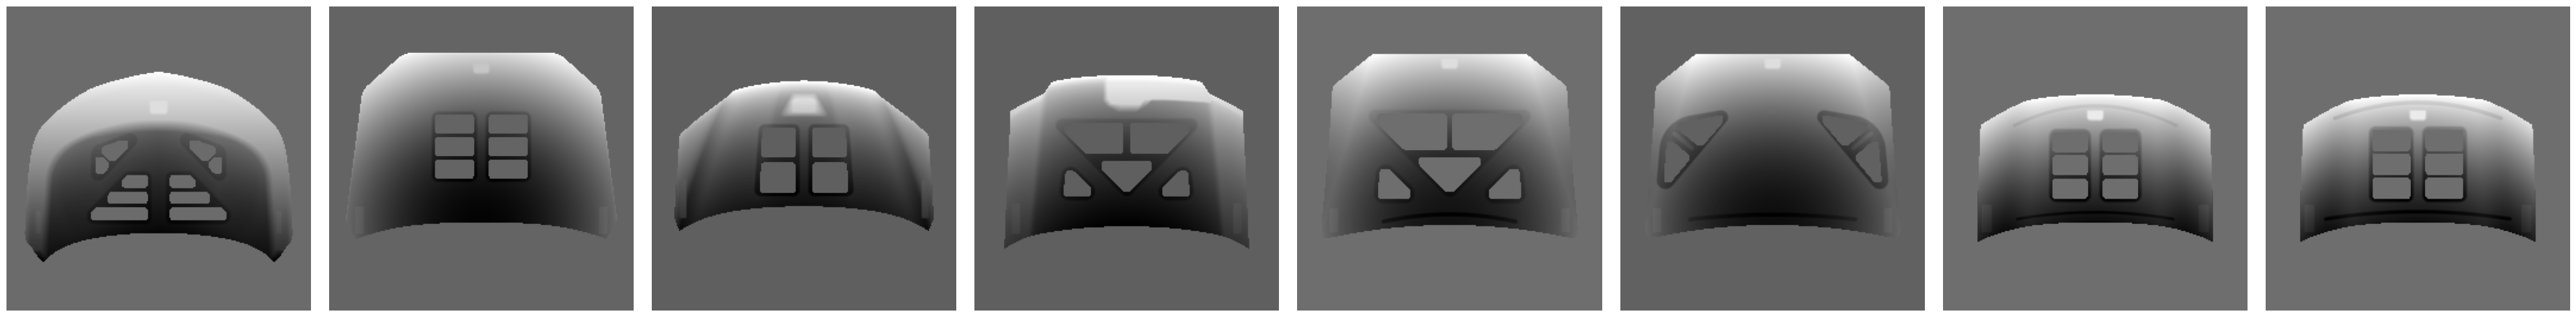

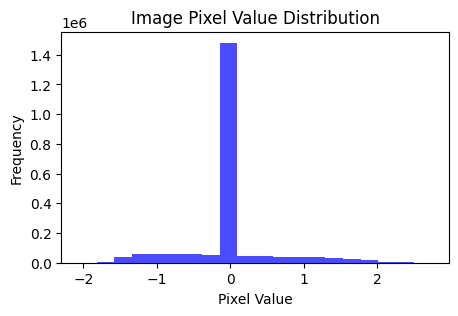

In [ ]:
df = pd.read_csv('./carhood_annot.csv')
data_dir = 'carhood_npy'
name_column =  'name'
var_columns = [cols[1], cols[2], cols[3]]
batch_size = 32

pp = CarHoodProcess(df, data_dir, name_column, var_columns, batch_size=batch_size, shuffle=True)
xs, ys = pp.get_batch(0)
print(xs.shape, ys.shape)
#print(ys[:8])
draw_imgs(xs[:8, 0])
draw_dist(xs)

**데이터 분할**

In [ ]:
df = pd.read_csv('./carhood_annot.csv')
train_df = df.sample(frac=0.95, random_state=42)
test_df = df.drop(train_df.index)
print(train_df.shape, test_df.shape)

(950, 5) (50, 5)


**Processor 구축**

In [ ]:
data_dir='./carhood_npy'
name_column='name'
var_columns=[cols[1], cols[2], cols[3]]
batch_size=32

train_pp = CarHoodProcess(train_df, data_dir, name_column, var_columns, batch_size=batch_size, shuffle=True)
test_pp = CarHoodProcess(test_df, data_dir, name_column, var_columns, batch_size=batch_size, shuffle=False, scaler=train_pp.scaler)


## **(2) 모델**
---

이번 시간에 사용할 모델은 `EfficientNet`입니다. `EfficientNet`은 신경망의 크기를 균형 있게 확장하여 높은 성능과 효율성을 달성하는 이미지 분류 모델입니다. 이 모델은 이미지넷 데이터셋에서 뛰어난 성능을 보였으며, 다양한 크기의 모델 변형이 제공됩니다.

`EfficientNet`은 `efficientnet_pytorch` 라이브러리에서 쉽게 불러올 수 있습니다. 이 라이브러리는 `PyTorch`에서 `EfficientNet` 모델을 간편하게 사용할 수 있도록 지원하며, 모델 가중치도 포함되어 있어 손쉽게 학습된 모델을 사용할 수 있습니다.



### **| Structure 구축**

* 이미지 출처 : (https://www.researchgate.net/figure/The-EffecientNet-B0-general-architecture_fig2_348470984)


![](https://www.researchgate.net/publication/348470984/figure/fig2/AS:979961129209859@1610652348348/The-EffecientNet-B0-general-architecture.png)

이 부분에서는 `EfficientNet` 기반 회귀 모델인 `EfficientNetRegressor`의 구조를 정의합니다.

```
- __init__ : 사전 학습된 `EfficientNet` 모델을 불러오고 문제에 맞게 적절히 변환합니다.
    - model_name : 불러 올 EfficientNet 의 버전을 선택합니다.
    - in_channels : 첫번째 컨볼루션 레이어의 입력 channel 개수 입니다.
    - out_features : 마지막 완전연결 레이어의 출력 feature 개수 입니다.

- forward : 입력 데이터를 모델에 전달하여 예측 값을 반환합니다.
```


In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

class EfficientNetRegressor(nn.Module):
    def __init__(self, model_name, in_channels=1, out_features=3):
        super(EfficientNetRegressor, self).__init__()
        self.base_model = EfficientNet.from_pretrained(model_name)
        self.base_model._conv_stem = nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.base_model._fc = nn.Linear(self.base_model._fc.in_features, out_features)

    def forward(self, x):
        return self.base_model(x)

**EfficientNet 모델 생성**


In [ ]:
effnet = EfficientNetRegressor('efficientnet-b0', in_channels=1, out_features=3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 214MB/s]

Loaded pretrained weights for efficientnet-b0


**모델 입력과 출력 확인**

In [ ]:
inputs = torch.randn(1, 1, 256, 256)  # (batch_size, channels, height, width)
outputs = effnet(inputs)
print(inputs.shape, outputs.shape)  # 예측 출력 shape 확인

torch.Size([1, 1, 256, 256]) torch.Size([1, 3])


### **| 모델 구축**

`PyTorch Lightning`을 사용하여 훈련, 검증, 최적화 루틴을 포함하는 `CarhoodPredictor`를 정의합니다.

```
- __init__ : 예측 모델(predictor)을 초기화합니다.
- forward : 입력 데이터를 예측 모델에 전달하여 출력을 반환합니다.
- configure_optimizers : Adam 옵티마이저와 코사인 조정 학습률 스케줄러를 설정합니다.
- training_step : 훈련 배치에서 입력 데이터와 타깃을 받아 모델 출력을 계산하고, MSE 손실을 계산하여 로깅합니다.
- validation_step : 검증 배치에서 입력 데이터와 타깃을 받아 모델 출력을 계산하고, MSE 손실을 계산하여 로깅합니다.
- fit : 훈련 및 검증 데이터를 사용하여 모델을 훈련합니다. 조기 종료와 체크포인트 저장 기능을 포함합니다.
- test_step : 테스트 배치에서 입력 데이터와 타깃을 받아 모델 출력을 계산하고, R² 점수와 MAE를 포함한 성능 지표를 로깅합니다.
- test : 테스트 데이터를 사용하여 모델 성능을 평가합니다.
- infer : 주어진 데이터 로더에서 예측을 수행하고, 필요 시 스케일러를 사용하여 예측값을 역변환합니다.
```

In [ ]:
import torch.nn as nn
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import  CSVLogger

from sklearn.metrics import r2_score, mean_absolute_error


class CarhoodPredictor(pl.LightningModule):
    def __init__(self, structure, *args, **kwargs):
        super().__init__()
        self.structure = structure

    def forward(self, x):
        x = self.structure(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.epochs)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss = nn.MSELoss()(output, target)
        lr = self.optimizers().param_groups[0]['lr']

        self.log('train_loss', loss)
        self.log('learning_rate', lr, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)
        loss =  nn.MSELoss()(output, target)
        lr = self.optimizers().param_groups[0]['lr']

        self.log('valid_loss', loss)
        return loss

    def fit(self, train_loader, save_dir,  valid_loader=None, init_lr=1e-3, epochs=10, patience=5):
        self.init_lr = init_lr
        self.epochs = epochs

        # valid loss 기준으로 최적 모델 저장하기
        if valid_loader is not None:
            monitor = 'valid_loss'
        else:
            monitor = 'train_loss'

        checkpoint_callback = ModelCheckpoint(
            dirpath=save_dir,
            filename='ckp_model',
            save_top_k=1,
            verbose=True,
            monitor=monitor,
            mode='min'
        )

        # Early stopping 적용하기
        early_stop_callback = EarlyStopping(
            monitor=monitor,
            patience=patience,
            verbose=True,
            mode='min'
        )

        # log
        csv_logger = CSVLogger(save_dir, name="csv_logs")

        # train
        self.trainer = Trainer(
            accelerator='cuda',
            max_epochs=epochs,
            default_root_dir=save_dir,
            callbacks=[checkpoint_callback, early_stop_callback],
            logger=[csv_logger],
            log_every_n_steps=len(train_loader)
        )

        self.trainer.fit(self, train_dataloaders=train_loader, val_dataloaders=valid_loader)


    def test_step(self, batch, batch_idx):
        data, target = batch
        output = self(data)

        r2_scores = [r2_score(target[:, i].detach().cpu(), output[:, i].detach().cpu()) for i in range(target.shape[1])]
        maes = [mean_absolute_error(target[:, i].detach().cpu(), output[:, i].detach().cpu()) for i in range(target.shape[1])]
        loss = nn.MSELoss()(output, target)

        # Log test metrics
        self.log('test_loss', loss)
        for i in range(target.shape[1]):
            self.log(f'test_r2_{i}', r2_scores[i], prog_bar=True)
            self.log(f'test_mae_{i}', maes[i], prog_bar=True)

    def test(self, data_loader, device='cuda'):
        self.trainer = Trainer(
            accelerator=device,
        )
        results = self.trainer.test(self, dataloaders=data_loader)
        return results


    def infer(self, loader, scaler=None):
        self.eval()
        preds=[]
        targets=[]
        for data, target in loader:
            with torch.no_grad():
                pred = self(data)
                preds.append(pred)
                targets.append(target.numpy())
        preds = np.concatenate(preds, axis=0)
        targets = np.concatenate(targets, axis=0)

        if scaler is not None:
            preds = scaler.inverse_transform(preds)
            targets = scaler.inverse_transform(targets)
        return preds, targets

### | **학습 및 평가**

**학습**

In [ ]:
train_loader = train_pp.get_loader()
test_loader = test_pp.get_loader()

model = CarhoodPredictor(structure=effnet)
model.fit(train_loader, save_dir='test_effnet', valid_loader=test_loader, epochs=100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/test_effnet exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | structure | EfficientNetRegressor | 4.0 M  | train
------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.043    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 1.134
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'valid_loss' reached 1.13381 (best 1.13381), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.070
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'valid_loss' reached 1.06966 (best 1.06966), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.148 >= min_delta = 0.0. New best score: 0.921
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'valid_loss' reached 0.92119 (best 0.92119), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.217 >= min_delta = 0.0. New best score: 0.704
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'valid_loss' reached 0.70434 (best 0.70434), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.697
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'valid_loss' reached 0.69664 (best 0.69664), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.118 >= min_delta = 0.0. New best score: 0.579
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 180: 'valid_loss' reached 0.57910 (best 0.57910), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 210: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.573
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 240: 'valid_loss' reached 0.57322 (best 0.57322), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.536
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 270: 'valid_loss' reached 0.53632 (best 0.53632), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.478
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 300: 'valid_loss' reached 0.47796 (best 0.47796), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.448
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 330: 'valid_loss' reached 0.44839 (best 0.44839), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.153 >= min_delta = 0.0. New best score: 0.295
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 360: 'valid_loss' reached 0.29491 (best 0.29491), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 390: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 420: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.234
INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 450: 'valid_loss' reached 0.23401 (best 0.23401), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 480: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.214
INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 510: 'valid_loss' reached 0.21429 (best 0.21429), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.174
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 540: 'valid_loss' reached 0.17439 (best 0.17439), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.161
INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 570: 'valid_loss' reached 0.16130 (best 0.16130), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.158
INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 600: 'valid_loss' reached 0.15800 (best 0.15800), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 630: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.143
INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 660: 'valid_loss' reached 0.14283 (best 0.14283), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 690: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 720: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.138
INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 750: 'valid_loss' reached 0.13795 (best 0.13795), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 780: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 810: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.138
INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 840: 'valid_loss' reached 0.13786 (best 0.13786), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.133
INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 870: 'valid_loss' reached 0.13274 (best 0.13274), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.131
INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 900: 'valid_loss' reached 0.13083 (best 0.13083), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.126
INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 930: 'valid_loss' reached 0.12566 (best 0.12566), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 960: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 990: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.124
INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 1020: 'valid_loss' reached 0.12410 (best 0.12410), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 1050: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.117
INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 1080: 'valid_loss' reached 0.11699 (best 0.11699), saving model to '/content/test_effnet/ckp_model.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 1110: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 1140: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 1170: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 1200: 'valid_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric valid_loss did not improve in the last 5 records. Best score: 0.117. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 1230: 'valid_loss' was not in top 1


**테스트**

In [ ]:
model = CarhoodPredictor.load_from_checkpoint('test_effnet/ckp_model.ckpt', structure=effnet)
model.test(test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.1169893816113472     │
│        test_mae_0         │    0.28947266936302185    │
│        test_mae_1         │    0.07480508089065552    │
│        test_mae_2         │    0.1470123678445816     │
│         test_r2_0         │    0.7032307386398315     │
│         test_r2_1         │    0.9906467199325562     │
│         test_r2_2         │    0.9505948424339294     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1169893816113472,
  'test_r2_0': 0.7032307386398315,
  'test_mae_0': 0.28947266936302185,
  'test_r2_1': 0.9906467199325562,
  'test_mae_1': 0.07480508089065552,
  'test_r2_2': 0.9505948424339294,
  'test_mae_2': 0.1470123678445816}]

**결과 시각화**

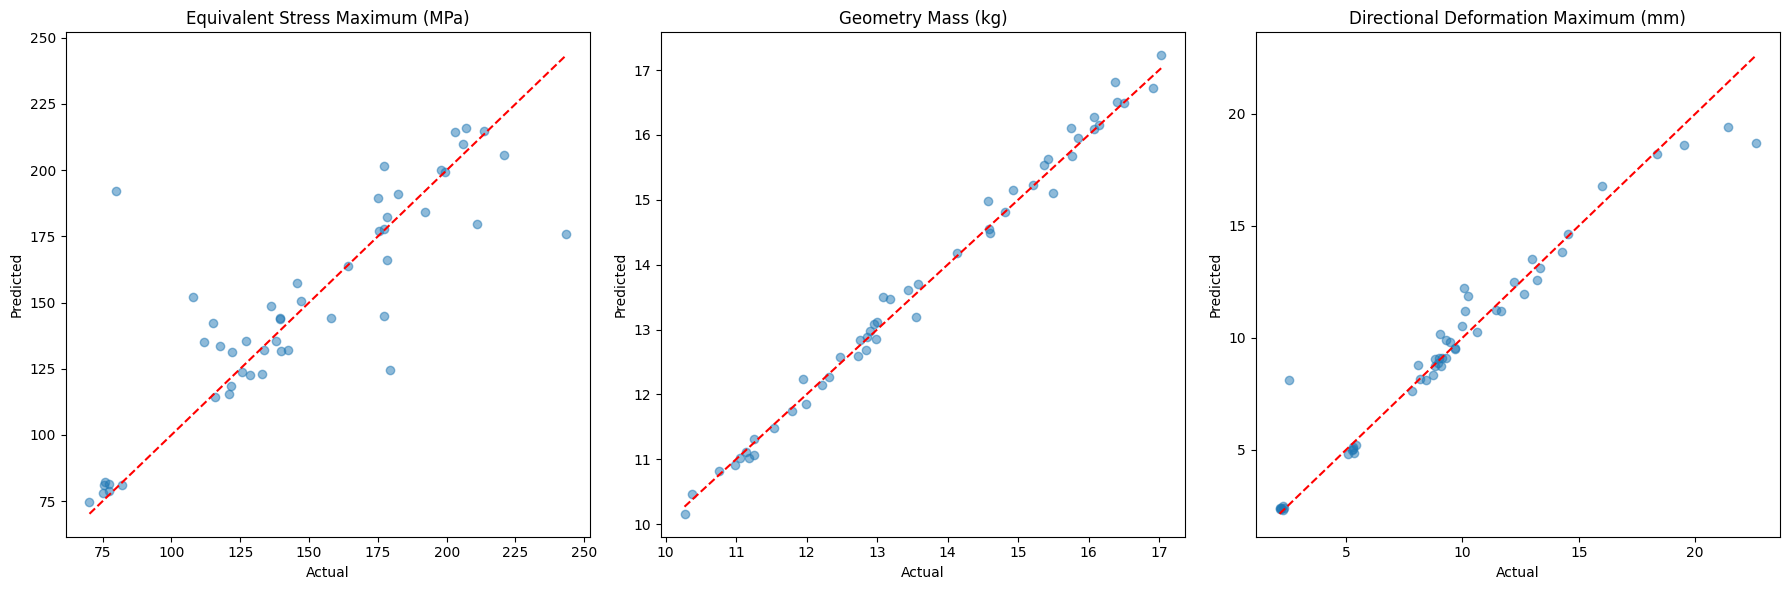

In [ ]:
preds, targets = model.infer(test_loader, scaler=train_pp.scaler)
draw_results(preds, targets, titles=var_columns)